In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import gzip
import os
import csv
from alive_progress import alive_bar
from collections import defaultdict
import time


c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, element_at, slice, size, regexp_extract, transform, when, explode, \
monotonically_increasing_id, map_from_arrays, lit, udf,collect_list, row_number, ceil, map_keys, expr, from_json
from pyspark.sql.types import ShortType, ArrayType, LongType, StringType
from pyspark.sql import types as T

import pandas as pd

#path = 'C:/Users/bincl/BA-Thesis/Dataset/2gram/2_20000_nopos_ab.gz'
start_date = 1800
end_date = 2000
directory_3gram = 'C:/Users/bincl/BA-Thesis/Dataset/2gram/parquet/'
directory_2gram = 'C:/Users/bincl/BA-Thesis/Dataset/1gram/parquet/'

spark = SparkSession.builder.appName('3gramSQL').getOrCreate()

df_3gram = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(directory_3gram)      

In [ ]:

df_2gram = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(directory_2gram)      

In [ ]:
# if id set as default parameter then a list is given if not a spark dataframe is given as parameter df
def get_pd_df(df):
    matched = df['Data'] 
    matched_pandas_df = pd.Series(matched)
    matched_pandas_df.sort_index(inplace = True)

    matched_pandas_df.index.astype('int')
    numbers = list(range(start_date,end_date))
    numbers = map(str, numbers)
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df

def get_pd_df_from_string(suchstring, df):
    x = df.select(['Tokens', 'Data']).where(df.Tokens == suchstring)
    matched = x.first()['Data']
    matched_pandas_df = pd.Series(matched)
    matched_pandas_df.sort_index(inplace = True)

    matched_pandas_df.index.astype('int')
    numbers = list(range(start_date,end_date))
    numbers = map(str, numbers)
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df

In [ ]:
# deprecated zu langsam
def find_n_gram(direc, find):
    for filename in os.listdir(direc):
        f = os.path.join(direc, filename)
        # checking if it is a file
        if os.path.isfile(f):
            with gzip.open(f,'rt', encoding='utf-8') as input:
                str_arr_csv = input.readlines()
                for line in str_arr_csv:
                    token = line.split("\t")
                    if find == token[0]:
                        return line
                        
    return "line not found" 

def start_the_search(directory,search):
    result = find_n_gram(directory,search)
    
    if result == "line not found":
        print(result)
        exit()
    result = result.split("\t")
    lower_ngram = pd.Series(result[1:],dtype= "string", name = result[0])
    return lower_ngram

In [ ]:
def getLowerLevelString(string):
   first, *middle, last = string.split()
   if len(middle) != 0:
        first = first + " " + ''.join(middle)
        last = ''.join(middle) + " " + last    
   return first, last

def MLR(token,data):
    y = data
    first,last = getLowerLevelString(token)
    first = get_pd_df_from_string(first,df_2gram)
    last = get_pd_df_from_string(last,df_2gram)
    X = pd.concat([first,last],axis=1)
    reg = LinearRegression()
    reg.fit(X, y) 
    return reg.coef_,reg.intercept_,X,y

def buildApproximation(c1,c2,basevalue,df):
    df = df.astype('float')
    
    df = df.fillna(0)
    
    df['scaledFirst'] = df.iloc[:,0].apply(lambda x: x * c1) 
    df['scaledLast'] = df.iloc[:,1].apply(lambda x: x * c2) 
    df['approximation'] = df['scaledFirst'] + df['scaledLast'] + basevalue
    return df

In [ ]:
def compressWithError2gram(n,error):
    df_3_gram = df_3gram.head(n)
    result = []
    all = []
    sum = []
    firstN = range(0,n)
    
    with alive_bar(len(firstN), force_tty = True, bar = 'smooth') as bar:
        for i in firstN:
            df_file = df_3_gram[i]
            data = get_pd_df(df_file)
            token = df_file['Tokens']
            if not(data.eq(0).all()):
                coef,intercept,dfAprox,original = MLR(token,data)
                c1,c2 = coef
                df = buildApproximation(c1,c2,intercept,dfAprox)
                dfOriginal = pd.DataFrame()
                dfOriginal['values'] = original
                dfOriginal['values'] = dfOriginal['values'].apply(pd.to_numeric, errors='coerce')
                #dfOriginal= pd.to_numeric(dfOriginal)
                dfOriginal['zscore'] = zscore(dfOriginal)
                df['zscore'] = zscore(df['approximation'])
                sum.append(pd.to_numeric(dfOriginal['values']).sum()) 
                #sum.append(df_file['Sum']) 
                rmse = mean_squared_error(dfOriginal['zscore'], df['zscore'], squared = False)
                #rmse = mean_squared_error(dfOriginal, df['approximation'])
                if rmse <= error:
                    result.append([token,rmse,dfOriginal['values'],dfOriginal['zscore'],df['approximation'],df['zscore']]) 
                all.append(rmse)    
            bar()
    return result, all, sum


In [ ]:
result, all, sum = compressWithError2gram(10000, 1)
print(sum)
print(all)
print(len(result))

|████████████████████████████████████████| 100/100 [100%] in 22.0s (4.53/s)     
[329, 5111, 244, 141, 806, 102, 39, 268, 79, 326, 76723, 69, 90, 1172, 144, 2962, 342, 46, 40, 38, 314, 29, 302, 135, 467, 375, 49, 52, 63, 106, 1283023, 1607, 5698, 127, 167, 442, 118, 149, 46, 31, 97, 193, 68, 147, 81, 129, 64, 45, 131, 391, 86, 23, 60, 88, 13, 32, 26, 107, 21, 59, 237, 3533, 1972, 244, 42, 49, 38, 2379, 69, 232, 128, 32, 469, 139, 11899, 554, 109, 182, 876, 1263, 120, 40, 1547, 3368, 277, 38, 43, 11243, 124, 3931, 173, 267, 521, 97, 96, 629, 12410, 117, 75088, 422]
[0.8637851331819647, 0.6186529272750023, 0.9042731689573291, 1.1621698156395128, 0.8903461115391639, 1.2264675798430489, 1.1519827926040533, 1.080063342638612, 1.1188022517630483, 1.1284301868379107, 0.7045967484522806, 1.1428729767011272, 1.2078390115723134, 0.8310488533979247, 1.2170496874820809, 0.5567203915577511, 1.2917085497170808, 1.308565364021953, 1.2821914487981048, 1.122742971283764, 1.0197693776307954, 1.319019520

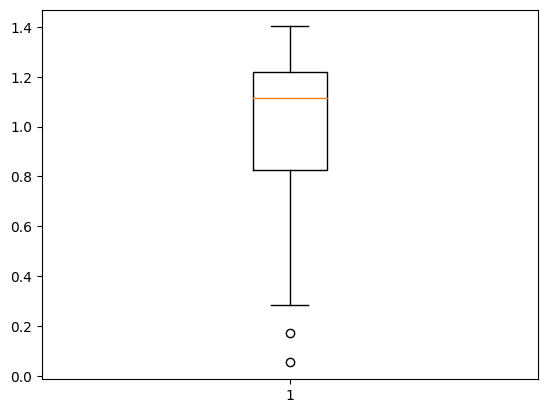

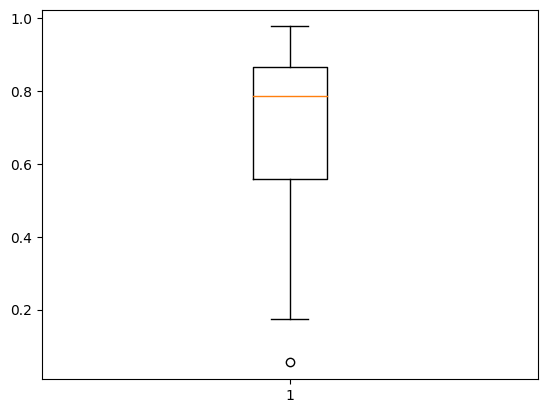

<AxesSubplot: >

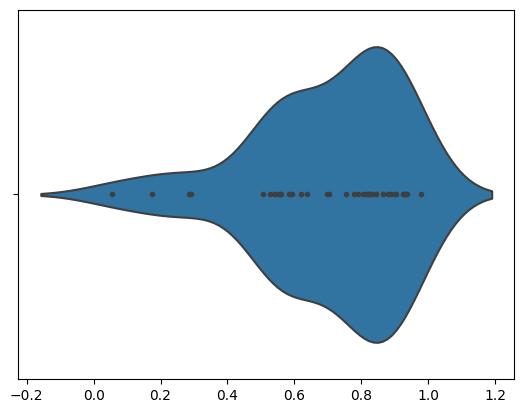

In [ ]:
plt.boxplot(all)
plt.show()
rmse_with_error = []

for i in result:
    rmse_with_error.append(i[1])
plt.boxplot(rmse_with_error)
plt.show()

import seaborn as sns

sns.violinplot(x= rmse_with_error, inner="point")

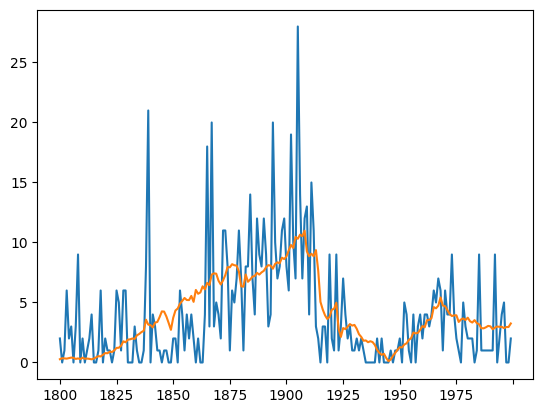

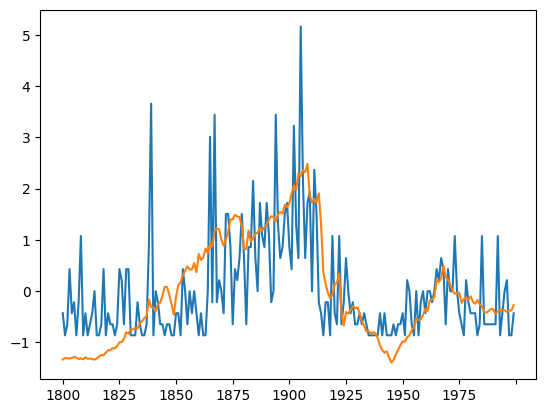

derselben einzuschränken
0.8903461115391639


In [ ]:
n = 3
result[n][2].plot()
result[n][4].plot()
plt.show()
result[n][3].plot()
result[n][5].plot()
plt.show()
print(result[n][0])
print(result[n][1])


<AxesSubplot: >

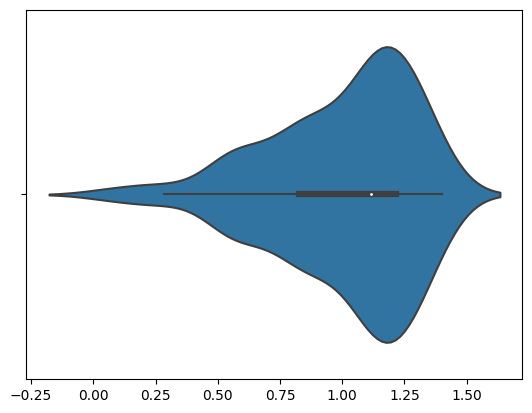

In [ ]:
sns.violinplot(x= all, inner_kws=dict(box_width=15, whis_width=2, color=".8"))

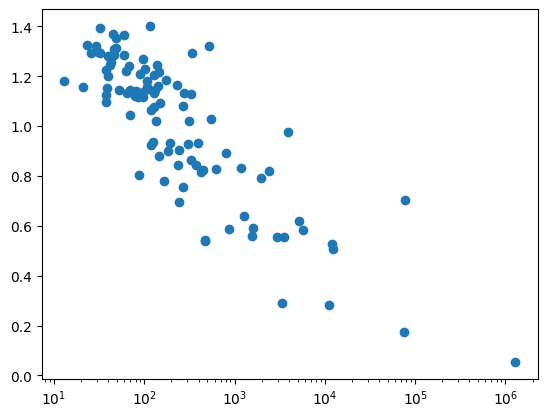

In [ ]:

plt.scatter(sum, all)
plt.xscale('log')
plt.show()